## A Business Decision

Since I'm fighting for people (including myself) to recognize that some of what I did in the past years also has *practical* (i.e., marketable 😬) relevance, let's imagine this business example that I am told is very important and ubiquitous:

You're running an avocado business with a website where people can sign up for your avocado delivery service. Now some smartass behavioral scientist sees your page and yells: "You could do so much better if you just knew something about how people allocate their attention and how it influences their decision-making!"

Now, you're also smart, so you pay this handsome fellow a handsome amount of money to give you some *actionable insights*✨ and improve your landing page. While your cognitive dissonance tries its hardest to convince you of how well the money was spent, you also paid a lot for your MBA, so you plan to run a proper experiment of the new design's effectiveness. 

### The Problem in Brief

Traditional frequentist testing must run the whole sample that was planned for and painfully mustn't peek at the results while data are coming in. That makes them inflexible and can bring you in weird situations: What if someone asks for intermediate results? Hm. You can report them, but act on them? Nope, that would [increase your chances of a false positive](reference).^[There are frequentist approaches for sequential testing, we'll get back to that.]

I'll demonstrate, how Bayesian sequential testing can be helpful to address these issues and can provide a more intuitive and actionable✨ interpretation of your data: Specifically it allows you to

- Check results **anytime** without penalty
- act on intermediate results, which could mean stoping your experiment earlier, saving time, money and opportunity.

Also, while I give this a business spin, the same concept applies in *research* questions: Whenever an intervention is tested against a control, the goal is to robustly assess if the intervention works. But it would also be nice (and in many cases the ethical thing to do) to save time, money, and call the decision as soon as you feel confident enough. Of course, you don't want to be *premature*. It's more like eating the avocado when it's just right, not still hard (too soon) or rotten (too late).

## What you were taught in statistics 101

The basic frequentist approach to this would include:

1. Run a power analysis to compute the required sample size
2. Collect all data - no peeking!
3. Run the test and make a decision

### Power analysis

First, let's determine the required sample size using traditional methods. The first variable we need to decide on is the effect size we want to be able to detect. Let's assume, our current data shows that your website has a sign-up rate of 5%. You expect the new design to improve this by 20% ("relative lift") to 6%, so we're looking to detect a 1% effect.  
Next, we need to determine the test's power, that is, the probability to find the effect, if the effect was real. In this case, we'd really hate to miss out on this opportunity of an improved website, so we'll set a high power of 90%.  
Finally, we need to define a false-positive rate that we're okay with. We'll stick to the regular α = 0.05, meaning that in 5% of studies like this, we'll conclude that there is an effect, even though there was just noise.

In [1]:
# | code-fold: false
# | code-summary: Import packages

# TODO remove before sharing
%load_ext autoreload 
%autoreload 2

# todo: strip to what's used
import matplotlib.pyplot as plt
import myplotlib as my
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

# Import our package
import src.bayesian_ab as bab

In [ ]:
# True rates
true_p_control = 0.10  # we have this from our pre-experiment data
relative_lift = 0.2  # minimum detectable effect in relative terms

# Run power analysis
# this function wraps statsmodels.stats.power.zt_ind_solve_power
power_result = bab.frequentist.power_analysis(
    p_control=true_p_control,
    relative_lift=relative_lift,
    power=0.80,
    alpha=0.05,
    alternative="larger",
)
print(power_result)

PowerAnalysisResult(n_per_group=3021, 
total_n=6042, effect_size=0.0640, 
power=0.80, alpha=0.05, 
p_control=0.1000, p_treatment=0.1200, 
relative_lift=0.2000)


Now we have a total sample size and we can compute how long this experiment would take to run, with our expected daily visitor number:

In [ ]:
daily_n_per_group = 200  # half our daily visitors
n_days = int(np.ceil(power_result.n_per_group / daily_n_per_group))
n_days
print(f"The experiment needs to run for {n_days} days.")

The experiment needs to run for 16 days.


### Run the experiment

Next, we'd run our experiment. Here, we'll simulate data instead, but make it look like it came in day by day, as it would in reality:

In [ ]:
# Simulate daily data
true_p_treatment = true_p_control * (1 + relative_lift)
data = bab.simulation.simulate_ab_test(
    n_days=n_days,
    daily_n=daily_n_per_group,
    p_a=true_p_control,
    p_b=true_p_treatment,
    seed=10439,
)

In [ ]:
# | code-fold: true
# | code-summary: Add some additional metrics to the data for visualization

# Add descriptive labels
data["design"] = data["variant"].map({"A": "Control", "B": "New Design"})
data["signups"] = data["conversions"]
data["visitors"] = data["n"]

# Add cumulative metrics
data["n_cum"] = data.groupby("variant")["n"].cumsum()
data["conversions_cum"] = data.groupby("variant")["conversions"].cumsum()

# Add confidence intervals for cumulative counts
ci = proportion_confint(
    count=data["conversions_cum"], nobs=data["n_cum"], method="wilson", alpha=0.05
)
data["ci_lower"] = ci[0]
data["ci_upper"] = ci[1]

# Little overview
data[["day", "design", "visitors", "signups"]].set_index(["day", "design"]).head(5)

visitors  signups
day design                       
1   Control          200       24
    New Design       200       20
2   Control          200       18
    New Design       200       19
3   Control          200       20

### Visualize Data Arrival

Let's see what our data look like:

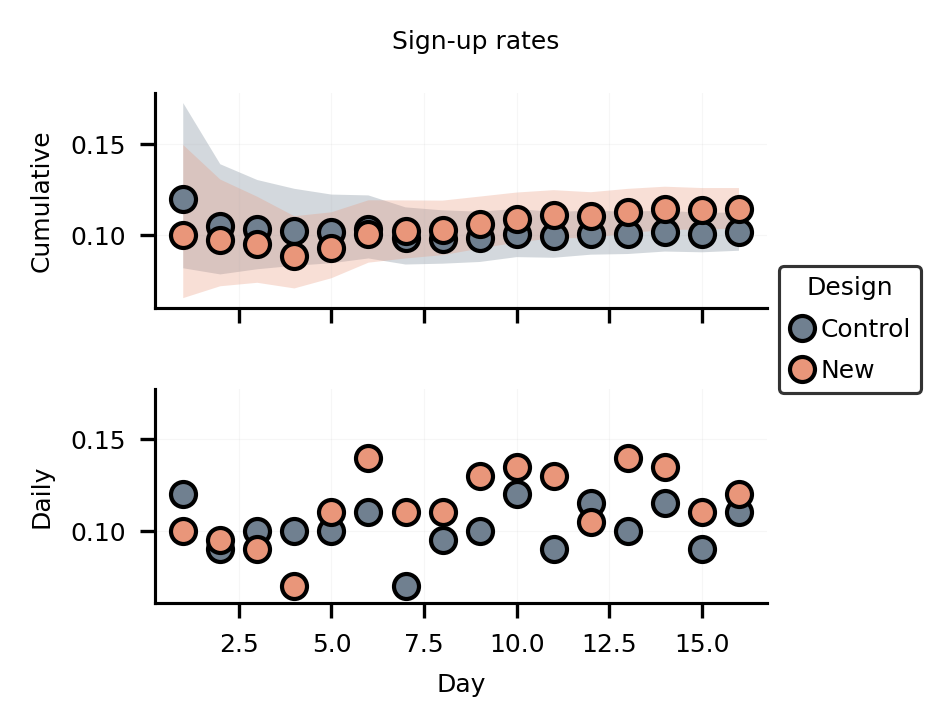

In [ ]:
# | label: fig-data
# | fig-cap: "Experiment data. The top panel shows sign-up rate data over the cumulative data. The bottom panel shows the sign-up rates for each day."
# | code-fold: true
# | code-summary: Show plotting function

fig, axs = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=my.utilities.cm2inch(8, 6)
)

labels = {"A": "Control", "B": "New"}

for v in ["A", "B"]:
    data_v = data.query("variant == @v")

    # Top: Daily cumulative proportion
    axs[0].plot(
        data_v["day"],
        data_v["conversions_cum"] / data_v["n_cum"],
        "o",
        clip_on=False,
        label=labels[v],
    )
    axs[0].fill_between(
        data_v["day"], data_v["ci_lower"], data_v["ci_upper"], alpha=0.3, zorder=-1
    )

    # Bottom: Daily proportion
    axs[1].plot(data_v["day"], data_v["conversions"] / data_v["n"], "o", clip_on=False)

# Labels
fig.suptitle("Sign-up rates")
axs[0].set_ylabel("Cumulative")
axs[1].set_ylabel("Daily")
axs[1].set_xlabel("Day")
# Ticks and Limits
# axs[0].set_ylim(0.03, 0.07)
# axs[0].set_yticks([0.03, 0.05, 0.07])
# axs[1].set_xticks([1, 5, 10, 15, 20])
for ax in axs:
    ax.grid(alpha=0.1, lw=0.25, fillstyle="top")
# axs[1].set_ylim(0, .1)
# Legend
axs[0].legend(bbox_to_anchor=(1, -0.1), loc="center left", title="Design")
# Layout
fig.tight_layout(h_pad=-0.3)
fig.align_ylabels()

Imagine seeing this data as it came in. On day one, you're really optimistic and can't wait to see how well the new landing page will perform. Think of all the avocados you will sell! At the end of the day, however, you mainly feel regret: The new design performed *worse* than your old trusted one. The new one doesn't even do any better than your historical average of 5%. You think about calling off the whole thing and asking for a refund, but then notice the huge error bars on those numbers (@fig-data; top panel) and decide to do the "right thing" and let the experiment run its course.  

In the next few days, however, your hopes for a bright avocado selling future are crushed even more. While the old design doesn't perform as well as on day one anymore, the new design keeps on tanking more. You call your data scientist who runs the study, but they've called in sick (because they too saw the data coming in...). You have no chance but to let the experiment roll.  

And what a twist. starting from day five, the new design (almost) consistently outperforms the old one and the long term sign-up rates (@fig-data; top panel) indicate a solid 1% increase.

### Run the test

After data are collected, the next step is to run our test. Specifically, we're running a [$z$-test]([$z$-test](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html)) on two the proportions:

In [ ]:
# Run traditional frequentist test (wraps statsmodels.stats.proportion.proportions_ztest)
freq_result = bab.frequentist.proportion_test(data, alpha=0.05, alternative="larger")
freq_result

ProportionTestResult(z_statistic=1.6514, 
p_value=0.0493, significant=True, 
alpha=0.05, rate_a=0.1016, 
rate_b=0.1144, absolute_lift=0.0128, 
relative_lift=0.1262, ci_a=(0.0910964277480344, 0.1120285722519656), 
ci_b=(0.10334784220593264, 0.12540215779406738), n_a=3200, n_b=3200, 
alternative='larger')

Hallelujah, what a ride! The $p$-value is below the magical limit of 0.05. The effect is significant💞. Life is good. Science works.

## The Bayesian Way

You're elated, but confused. How could the intermediate results have been so misleading? The complicated truth is that you were not supposed to look at the data at all in the first place, but it's so hard to do that in an increasingly agile✨ world. 

I want to present an alternative view to do this, that does not need to wait for all data to be collected to make meaningful statements: A Bayesian way.

Without giving a whole course on Bayesian statistics here, here's the upshot: In Bayesian statistics, you use probability distributions to describe your beliefs (or uncertainty, or confidence) about statistical parameters. And importantly, these distributions change by means of observing data. In Bayes lingo, you have a prior belief about a variable of interest (e.g., the sign-up rate in the new group) and adjust it by incorporating *data* by means of their *likelihood*. Your updated belief is now called *posterior* and is ready to be updated again with more data. You see, how this procedure lends itself to sequential analysis naturally?

This makes it so we can talk about the data at any time! There is no time horizon that we have to wait for. At each point in time, we can say *something* true - and importantly, also do something with that information.

In the case of sign up rates, a useful statistical model is the [Beta-Binomial model](https://en.wikipedia.org/wiki/Beta-binomial_distribution) and it's so straightforward that it's often used as the introductory example in Bayes statistics literature.

It assumes that sign-up events are Bernoulli trials, that is they happen with probability $p$ and not happen with probability $1-p$. That probability $p$ is what we want to measure and compare in our A/B test. While frequentists would estimate that probability as the observed relative frequency, compute confidence intervals and then run a test on resulting two point-estimates, Bayesians use probability distributions to describe our information about those quantities of interest - including all uncertainty.

For the Beta-Binomial model, this is done with the Beta distribution. It has two parameters that correspond to the number of sign-ups and visits not resulting in sign-up. It gets narrower with more data, meaning that our estimate of where the true probability $p$ is gets more accurate.

Let's see how this distribution evolves over time in our experiment:

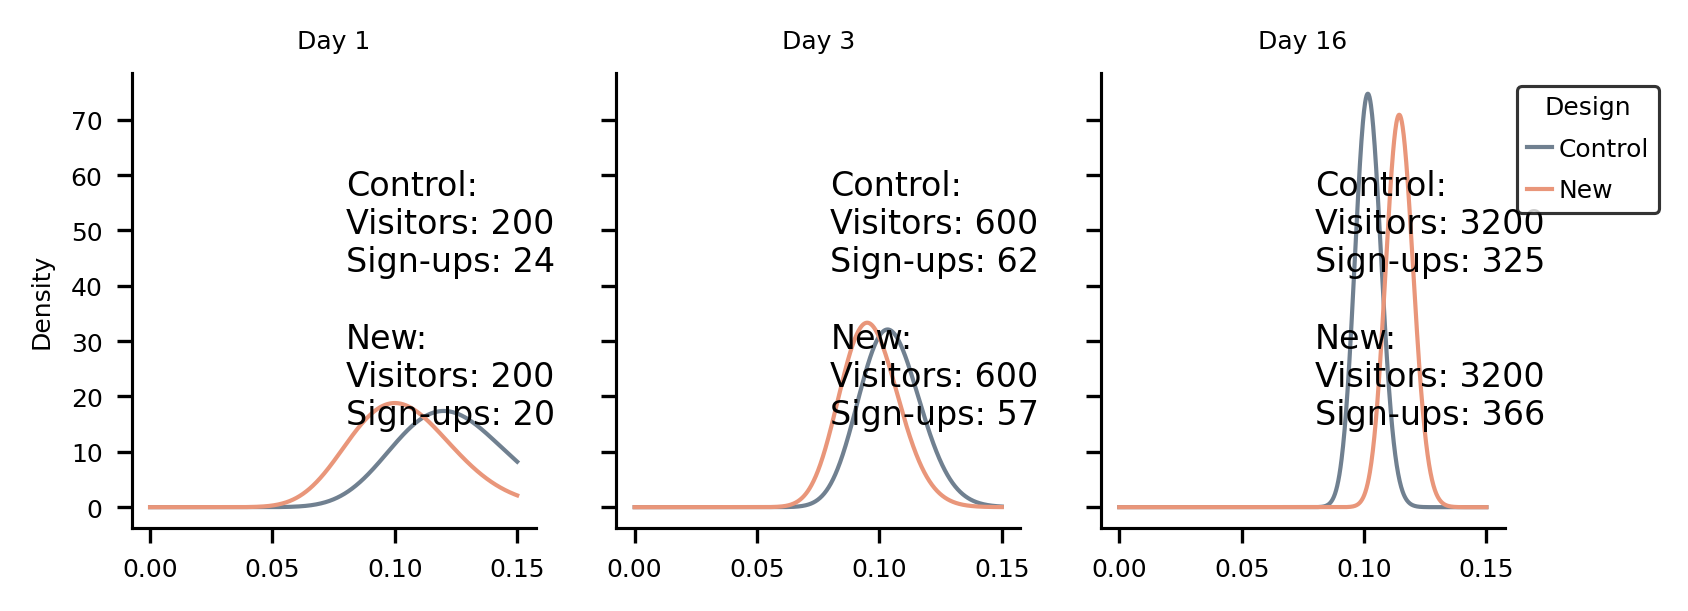

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=my.utilities.cm2inch(15, 5), sharey=True)

x = np.linspace(0, 0.15, 1000)

for i, day in enumerate([1, 3, n_days]):
    ax = axs[i]
    data_day = data.query("day == @day")
    post_control = stats.beta(
        1 + data_day.query("variant == 'A'")["conversions_cum"].values[0],
        1
        + data_day.query("variant == 'A'")["n_cum"].values[0]
        - data_day.query("variant == 'A'")["conversions_cum"].values[0],
    )
    post_treatment = stats.beta(
        1 + data_day.query("variant == 'B'")["conversions_cum"].values[0],
        1
        + data_day.query("variant == 'B'")["n_cum"].values[0]
        - data_day.query("variant == 'B'")["conversions_cum"].values[0],
    )
    ax.plot(x, post_control.pdf(x), label="Control", color="C0")
    ax.plot(x, post_treatment.pdf(x), label="New", color="C1")
    ax.set_title(f"Day {day}")

    ax.text(
        0.08,
        15,
        f"Control:\nVisitors: {data_day.query('variant == \"A\"')['n_cum'].values[0]}\n"
        f"Sign-ups: {data_day.query('variant == \"A\"')['conversions_cum'].values[0]}\n\n"
        f"New:\nVisitors: {data_day.query('variant == \"B\"')['n_cum'].values[0]}\n"
        f"Sign-ups: {data_day.query('variant == \"B\"')['conversions_cum'].values[0]}",
        fontsize=8,
    )
    if i == 0:
        ax.set_ylabel("Density")
    if i == 2:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Design")

What I really enjoy about the Bayesian framework is that we can take these probability distributions and make a lot of different statements - each of which might be interesting to us. And it doesn't stop at statements: We might decide to *act* on these results, too, for example by stopping the experiment and implementing the new design for all users. Bayesian analysis is a machine for actual *actionable insights*✨!

The most basic statements we can make would be: What's our current best guess about the sign-up rate in the new design, and how certain are we about this? For this, we could look at the peak of the posterior distribution for the new design. Regarding uncertainty, we can construct an interval that contains 92% of posterior density (we're not bound to 5% or any other magic value).

Another metric very close to our initial question of "Is the new design better?": We can look that the probability that the sign-up rate for the new design is higher than that of the old one. We can compute this at each point in time:

In [ ]:
# Probability that B (new design) is better than A (control)
# Using Monte Carlo sampling from the posterior distributions

n_samples = 100_000

# Sample from each posterior
samples_a = post_control.rvs(n_samples)
samples_b = post_treatment.rvs(n_samples)

# P(B > A) is simply the proportion of samples where B > A
prob_b_better = np.mean(samples_b > samples_a)
print(f"P(new design > control) = {prob_b_better:.1%}")

P(new design > control) = 95.1%


Note callout: Sampling
Note, that we're using Monte Carlo simulations instead of going through complicated formal analysis for the probability distributions. Computers can run these simulations really quickly, and the results be precise enough. In future posts, we'll build more complex models where the analytical approach gets even more prohibitive, so we'll make more use of sampling (then using PyMC).


We're really flexible with these probability distributions. So we could go one step further and compute more evolved metrics of information:

Maybe we deem a range of ±1% of change not really relevant (we're looking for a new design with a more striking effect). With this "region of practical equivalence", we could ask: "What is the probability that the new design has a sign-up rate that's higher than that?"


In [ ]:
# Region of Practical Equivalence (ROPE)
# We define a range where differences don't matter practically

rope_width = 0.01  # ±1 percentage point

# Compute the difference in sign-up rates
diff_samples = samples_b - samples_a

# P(difference > ROPE) = P(new design is meaningfully better)
prob_above_rope = np.mean(diff_samples > rope_width)
print(f"P(new design > control + {rope_width:.0%}) = {prob_above_rope:.1%}")

P(new design > control + 1%) = 64.4%


Another practical measure could be one quantifying opportunity cost by not implementing a new design right-away, so-called expected loss.
This might make a lot of sense in a business setting, because it makes your decision-making extremely quantifiable (in terms of actual money):

In [ ]:
# Expected Loss: opportunity cost of choosing wrong variant
# If we pick A but B is better, we lose (p_B - p_A) per visitor

# Loss from choosing A (control): how much we lose if B was actually better
loss_if_choose_a = np.maximum(samples_b - samples_a, 0)
expected_loss_a = np.mean(loss_if_choose_a)

# Loss from choosing B (new design): how much we lose if A was actually better
loss_if_choose_b = np.maximum(samples_a - samples_b, 0)
expected_loss_b = np.mean(loss_if_choose_b)

print(
    f"Expected loss if we choose control:    {expected_loss_a:.4f} ({expected_loss_a:.2%} per visitor)"
)
print(
    f"Expected loss if we choose new design: {expected_loss_b:.4f} ({expected_loss_b:.2%} per visitor)"
)

Expected loss if we choose control:    0.0130 (1.30% per visitor)
Expected loss if we choose new design: 0.0002 (0.02% per visitor)



Now let's do the Bayesian updating procedure over the course of each day and keep track of variables of interest at each point.

In [ ]:
# Bayesian sequential updating: track metrics day by day
n_samples = 100_000
results = []

for day in range(1, n_days + 1):
    # Get cumulative data up to this day
    data_day = data.query("day == @day")

    n_a = data_day.query("variant == 'A'")["n_cum"].values[0]
    n_b = data_day.query("variant == 'B'")["n_cum"].values[0]
    conv_a = data_day.query("variant == 'A'")["conversions_cum"].values[0]
    conv_b = data_day.query("variant == 'B'")["conversions_cum"].values[0]

    # Posterior distributions (Beta with uniform prior: alpha=1, beta=1)
    post_a = stats.beta(1 + conv_a, 1 + n_a - conv_a)
    post_b = stats.beta(1 + conv_b, 1 + n_b - conv_b)

    # Sample from posteriors
    samples_a = post_a.rvs(n_samples)
    samples_b = post_b.rvs(n_samples)

    # Compute metrics
    prob_b_better = np.mean(samples_b > samples_a)
    expected_loss_b = np.mean(np.maximum(samples_a - samples_b, 0))
    prob_above_rope = np.mean((samples_b - samples_a) > rope_width)

    results.append(
        {
            "day": day,
            "prob_b_better": prob_b_better,
            "expected_loss_b": expected_loss_b,
            "prob_above_rope": prob_above_rope,
        }
    )

results_df = pd.DataFrame(results)
results_df.head(20)

,day,prob_b_better,expected_loss_b,prob_above_rope
0,1,0.26313,0.024961,0.16824
1,2,0.36451,0.012785,0.20765
2,3,0.31542,0.011814,0.14426
3,4,0.17470,0.015150,0.05334
4,5,0.24782,0.010983,0.07621
5,6,0.41896,0.006295,0.15647
6,7,0.62180,0.002977,0.28571
7,8,0.68066,0.002199,0.31740
8,9,0.77858,0.001274,0.41405
9,10,0.81046,0.001003,0.43933


Can stop on day 16 with 95% confidence
vs. 16 days for traditional testing (0% reduction)


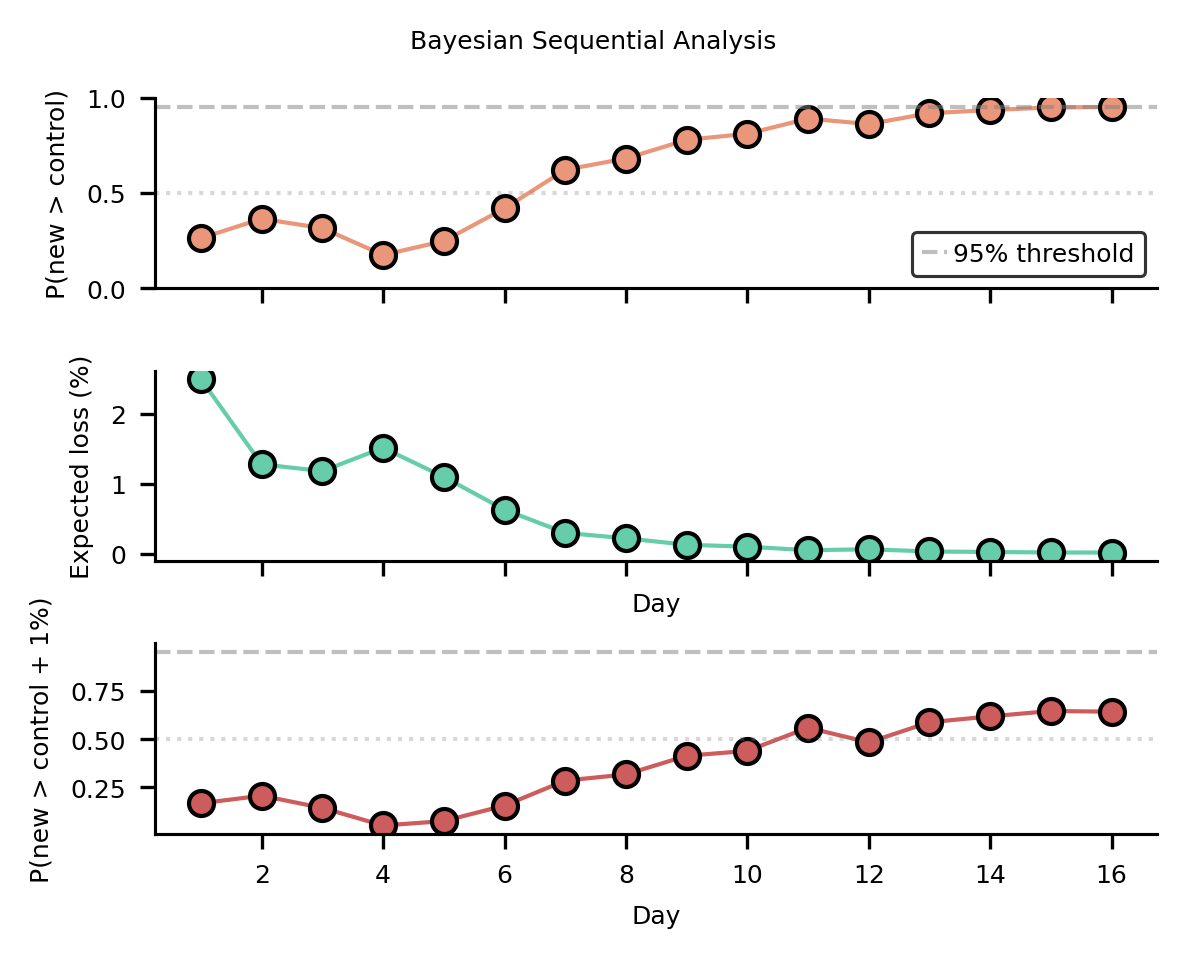

In [13]:
# | code-fold: true
# | code-summary: Show code

fig, axs = plt.subplots(3, 1, figsize=my.utilities.cm2inch(10, 8), sharex=True)

# Top: P(B > A) over time
axs[0].plot(results_df["day"], results_df["prob_b_better"], "o-", color="C1")
axs[0].axhline(0.95, color="gray", linestyle="--", alpha=0.5, label="95% threshold")
axs[0].axhline(0.5, color="gray", linestyle=":", alpha=0.3)
axs[0].set_ylabel("P(new > control)")
axs[0].set_ylim(0, 1)
axs[0].legend(loc="lower right")

# Bottom: Expected loss over time
axs[1].plot(results_df["day"], results_df["expected_loss_b"] * 100, "o-", color="C2")
axs[1].set_ylabel("Expected loss (%)")
axs[1].set_xlabel("Day")

axs[2].plot(results_df["day"], results_df["prob_above_rope"], "o-", color="C3")
axs[2].axhline(0.95, color="gray", linestyle="--", alpha=0.5, label="95% threshold")
axs[2].axhline(0.5, color="gray", linestyle=":", alpha=0.3)
axs[2].set_ylabel("P(new > control + 1%)")
axs[2].set_xlabel("Day")

fig.suptitle("Bayesian Sequential Analysis")
fig.tight_layout()

# Report stopping time
stop_day = results_df[results_df["prob_b_better"] >= 0.95]["day"].min()
if pd.notna(stop_day):
    savings = 100 * (1 - stop_day / n_days)
    print(f"Can stop on day {int(stop_day)} with 95% confidence")
    print(f"vs. {n_days} days for traditional testing ({savings:.0f}% reduction)")
else:
    print("Need more days to reach 95% confidence")

## Acknowledgments & Further Reading

**Educational Purpose:** This notebook is a learning exercise for understanding Bayesian sequential A/B testing. While the concepts are well-established in industry and academia, implementing them from scratch has been valuable for deepening my statistical intuition. I hope it's useful for others learning these methods too.

**This is Not Novel:** Bayesian sequential testing for A/B tests is well-established:
- VWO implemented this approach in production in 2015 ([technical whitepaper](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf))
- Academic foundations date back decades (see Berger & Berry, 1988)
- Many SaaS platforms (VWO, Dynamic Yield, AB Tasty) use these methods

**Essential Reading:**

*Bayesian A/B Testing:*
- [Evan Miller's "Simple Sequential A/B Testing"](https://www.evanmiller.org/sequential-ab-testing.html) - Accessible introduction
- [Chris Stucchio's "Bayesian A/B Testing at VWO"](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf) - Implementation details
- [David Robinson's "Is Bayesian A/B Testing Immune to Peeking?"](http://varianceexplained.org/r/bayesian-ab-testing/) - Important critique showing Bayesian methods are NOT peeking-proof

*Industry Practice:*
- [Microsoft's ExP Platform](https://www.exp-platform.com/) - How large tech companies actually run experiments (frequentist methods)
- [Spotify's Sequential Testing Framework Comparison](https://engineering.atspotify.com/2023/03/choosing-sequential-testing-framework-comparisons-and-discussions) - Detailed analysis of GST vs. mSPRT vs. GAVI

*Key Papers:*
- Johari et al. (2021) "[Always Valid Inference](https://arxiv.org/abs/1512.04922)" - Frequentist sequential testing foundations
- Deng et al. (2013) "[Improving the Sensitivity of Online Controlled Experiments](https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf)" - CUPED variance reduction

**Alternative Approaches Not Covered Here:**

This notebook focuses on simple Bayesian sequential testing, but industry has developed other important methods:

- **CUPED (Controlled-experiment Using Pre-Experiment Data)** - Variance reduction using pre-experiment covariates; can reduce experiment time by 50-65%. Used by Microsoft, Netflix, Meta. [Paper](https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf)

- **Group Sequential Tests (GST)** - Frequentist sequential testing with alpha spending functions; maintains valid Type I error control. Used by Spotify, LinkedIn. [Jennison & Turnbull, 1999](https://www.jstor.org/stable/2673986)

- **Anytime-Valid Inference** - Methods providing valid p-values regardless of when you stop. Used by Netflix. [Ramdas et al., 2020](https://arxiv.org/abs/1810.08240)

- **Multi-Armed Bandits** - Adaptive allocation that sends more traffic to better variants; trades statistical confidence for reduced regret. [See Optimizely's implementation](https://www.optimizely.com/optimization-glossary/multi-armed-bandit/)

**Why These Matter:** Major tech companies (Google, Microsoft, Amazon, Netflix) primarily use frequentist methods with variance reduction and sequential testing. Bayesian methods have found their niche in mid-market SaaS platforms where interpretability is valued. Understanding both approaches and when each adds value is more important than dogmatic framework preference.

**What's Actually Novel in This Notebook:** The comparison framework, expected loss stopping criteria, and hopefully a clear pedagogical explanation of the tradeoffs.

## Future Directions

**This notebook covers the simplest case:** two variants, binary outcome, independent observations. Both frequentist and Bayesian approaches handle this well.

**Bayesian methods become increasingly valuable for:**
- **Hierarchical models** - Testing across segments (mobile/desktop/tablet) with partial pooling
- **Covariate adjustment** - Modeling time-of-day effects, user characteristics, or complex regression structures
- **Non-standard metrics** - Revenue (continuous), time-to-conversion (survival), or heavy-tailed distributions
- **Incorporating historical data** - Using past experiments to inform priors for new tests

Future articles may explore these extensions with PyMC. The conjugate prior foundation established here generalizes naturally to these more complex scenarios where MCMC sampling becomes necessary.